In [1]:
%run ../functions.ipynb

In [1]:
import george as gg
import george.kernels as kr
import scipy.optimize as op

In [3]:
pd.options.display.max_rows = 6
pd.options.display.max_columns = 30

In [4]:
df = pd.read_pickle("../../data/processed/df_raw.pkl")

In [5]:
df

,ID,desg,desi,desr,desz,Xaxis
0,SN554563,"[[0.0, 18.98, 10.49], [1.985000000000582, 0.89...","[[0.03200000000651926, 8.001, 9.313], [10.9610...","[[2.0, 5.875, 2.431], [10.121000000006461, 6.9...","[[15.993000000002212, 1.763, 6.543], [29.95700...","[0.0, 1.4326868686868988, 2.8653737373737975, ..."
1,SN454964,"[[0.0, 4.359, 6.2], [4.9799999999959255, 33.82...","[[0.010999999998603016, 3.629, 6.148], [4.9959...","[[0.004000000000814907, 0.8701, 3.584], [14.21...","[[5.004000000000815, 4.406, 7.695], [24.139999...","[0.0, 1.2527575757575864, 2.505515151515173, 3..."
2,SN537864,"[[0.0, 0.4987, 4.764], [11.969000000004598, 8....","[[4.105999999999767, 1.357, 3.683], [13.090000...","[[0.008000000001629815, 3.18, 2.13], [13.07899...","[[3.0750000000043656, 1.838, 3.729], [4.137000...","[0.0, 1.1715252525252502, 2.3430505050505004, ..."
...,...,...,...,...,...,...
21314,SN51813,"[[14.859000000004016, 11.64, 11.89], [30.91799...","[[12.984000000004016, 5.321, 4.986], [22.88599...","[[0.0, 1.53, 1.444], [14.86699999999837, 2.602...","[[2.014999999999418, 3.934, 3.402], [13.014999...","[0.0, 0.7759595959595931, 1.5519191919191861, ..."
21315,SN599115,"[[0.0, 3.229, 7.693], [10.014999999999418, 1.1...","[[0.027000000001862645, 8.224, 5.11], [3.01099...","[[1.0, 0.9777, 3.85], [2.0429999999978463, 0.4...","[[1.0429999999978463, 2.444, 4.848], [2.085999...","[0.0, 1.2428181818181518, 2.4856363636363037, ..."
21316,SN308423,"[[29.875, 4.829, 11.89], [53.88699999999517, 9...","[[0.0, 2.278, 4.54], [7.995999999999185, 3.879...","[[2.069999999999709, 0.06183, 1.853], [23.0239...","[[0.01999999999679858, 6.346, 3.061], [30.0159...","[0.0, 0.9276363636363202, 1.8552727272726404, ..."


In [16]:
gp = gg.GP((500**2)*kr.ExpSquaredKernel(metric=20**2), fit_mean=True)

In [10]:
# Define the function to apply on each cell 
# Intro is desg/desi... and the Xaxis respective to that row
def GP(des, x):
    gp = gg.GP((500**2)*kr.ExpSquaredKernel(metric=20**2), fit_mean=True)
    gp.compute(des[:,0], des[:,2])
    
    # Define the objective function (negative log-likelihood in this case).
    def nll(p):
        gp.set_parameter_vector(p)
        ll = gp.log_likelihood(des[:,1], quiet=True)
        return -ll if np.isfinite(ll) else 1e25

    # And the gradient of the objective function.
    def grad_nll(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(des[:,1], quiet=True)
    
    p0 = gp.get_parameter_vector()
    results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
    mu, var = gp.predict(des[:,1], x, return_var=True)
    std = np.sqrt(var)
    return mu, std




df['desg_GP'] = df.apply(lambda df: GP(df.desg, df.Xaxis), axis=1) 
df['desi_GP'] = df.apply(lambda df: GP(df.desi, df.Xaxis), axis=1) 
df['desr_GP'] = df.apply(lambda df: GP(df.desr, df.Xaxis), axis=1) 
df['desz_GP'] = df.apply(lambda df: GP(df.desz, df.Xaxis), axis=1) 
df.to_pickle("./df_GP.pkl")

/home/felipe/anaconda3/lib/python3.7/site-packages/george/gp.py:410: RuntimeWarning: invalid value encountered in subtract
  A = np.einsum("i,j", alpha, alpha) - K_inv


In [11]:
df_GP = pd.read_pickle("../../data/processed/df_GP.pkl")

In [12]:
df_GP

,ID,desg,desi,desr,desz,Xaxis,desg_GP,desi_GP,desr_GP,desz_GP
0,SN554563,"[[0.0, 18.98, 10.49], [1.985000000000582, 0.89...","[[0.03200000000651926, 8.001, 9.313], [10.9610...","[[2.0, 5.875, 2.431], [10.121000000006461, 6.9...","[[15.993000000002212, 1.763, 6.543], [29.95700...","[0.0, 1.4326868686868988, 2.8653737373737975, ...","([5.746648796695705, 5.746648932880543, 5.7466...","([11.454687362516403, 11.709289861025216, 11.9...","([4.890760152046546, 5.310257419596397, 5.7590...","([-0.9333255737994115, -0.6342774502391997, -0..."
1,SN454964,"[[0.0, 4.359, 6.2], [4.9799999999959255, 33.82...","[[0.010999999998603016, 3.629, 6.148], [4.9959...","[[0.004000000000814907, 0.8701, 3.584], [14.21...","[[5.004000000000815, 4.406, 7.695], [24.139999...","[0.0, 1.2527575757575864, 2.505515151515173, 3...","([2.5129421342321345, 2.512943454147988, 2.512...","([1.2656190996984247, 1.364093318574012, 1.466...","([-0.4577396960412159, -0.3644574657241577, -0...","([4.978011638069539, 5.120731330305979, 5.2642..."
2,SN537864,"[[0.0, 0.4987, 4.764], [11.969000000004598, 8....","[[4.105999999999767, 1.357, 3.683], [13.090000...","[[0.008000000001629815, 3.18, 2.13], [13.07899...","[[3.0750000000043656, 1.838, 3.729], [4.137000...","[0.0, 1.1715252525252502, 2.3430505050505004, ...","([0.36263759198706325, 1.0110664309436146, 1.6...","([3.3104549609878404, 2.476451163370484, 1.614...","([3.061288207653913, 2.3887689057221593, 1.621...","([-0.13900238963090317, -0.2814609436568247, -..."
...,...,...,...,...,...,...,...,...,...,...
21314,SN51813,"[[14.859000000004016, 11.64, 11.89], [30.91799...","[[12.984000000004016, 5.321, 4.986], [22.88599...","[[0.0, 1.53, 1.444], [14.86699999999837, 2.602...","[[2.014999999999418, 3.934, 3.402], [13.014999...","[0.0, 0.7759595959595931, 1.5519191919191861, ...","([2.241783614460949, 2.5132823043975097, 2.799...","([18.73675226792541, 18.255681160927438, 17.69...","([1.577751208615716, 2.1330528995902043, 2.640...","([4.2052639508309255, 4.512857550522114, 4.748..."
21315,SN599115,"[[0.0, 3.229, 7.693], [10.014999999999418, 1.1...","[[0.027000000001862645, 8.224, 5.11], [3.01099...","[[1.0, 0.9777, 3.85], [2.0429999999978463, 0.4...","[[1.0429999999978463, 2.444, 4.848], [2.085999...","[0.0, 1.2428181818181518, 2.4856363636363037, ...","([0.7025017623961566, 0.7451500687503885, 0.78...","([7.15703258314026, 7.111139809418558, 7.02847...","([1.1335809355909596, 1.8321607810149452, 2.52...","([2.4798831358520523, 2.606082545590933, 2.734..."
21316,SN308423,"[[29.875, 4.829, 11.89], [53.88699999999517, 9...","[[0.0, 2.278, 4.54], [7.995999999999185, 3.879...","[[2.069999999999709, 0.06183, 1.853], [23.0239...","[[0.01999999999679858, 6.346, 3.061], [30.0159...","[0.0, 0.9276363636363202, 1.8552727272726404, ...","([0.00011369119169849187, 0.000113785235593432...","([2.818078927887593, 2.9275385392203095, 3.031...","([0.1024856271485491, 0.12407885793497937, 0.1...","([5.545040757089959, 5.4250737096306825, 5.297..."


/home/felipe/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/felipe/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


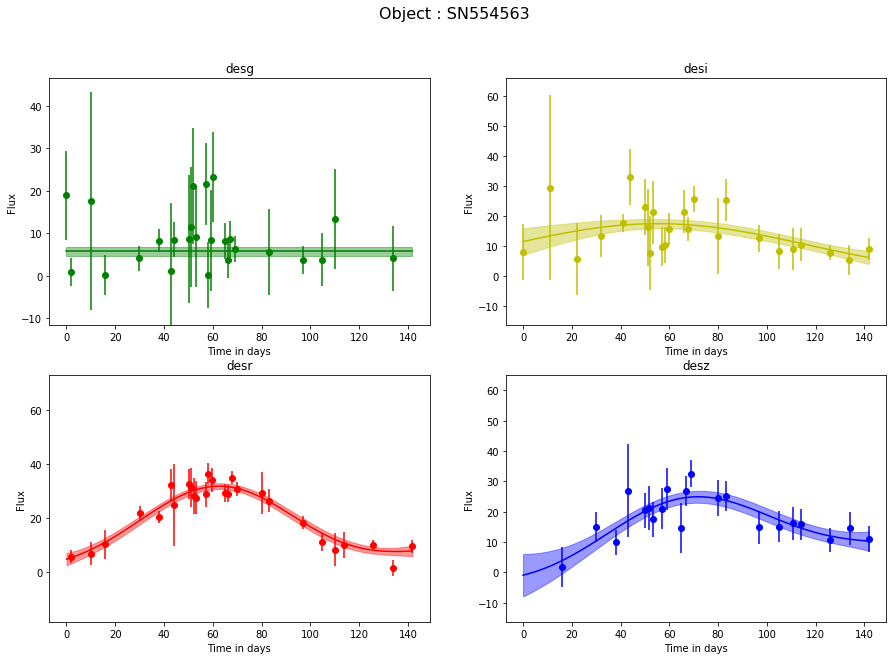

In [13]:
print_filters(df_GP.iloc[0])